In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu118
cuda:0


# 数据准备
训练模型时会把数据分为训练集、验证集和测试集。而非训练集和测试集，这是为了防止人工调参时信息泄露。

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms


# 定义数据集的变换
# 转换为tensor，进行归一化
transform = transforms.Compose([transforms.ToTensor(),])
# transforms.Normalize(mean, std) # 标准化，mean和std是数据集的均值和方差，对于这个模型经过标准化后效果会更好

# fashion_mnist图像分类数据集，衣服分类，60000张训练图片，10000张测试图片
train_ds = datasets.FashionMNIST(
    root="G:/wangdao_python_short_class/chapter_2_torch/data",
    train=True,
    download=True,
    transform=transform
)

test_ds = datasets.FashionMNIST(
    root="G:/wangdao_python_short_class/chapter_2_torch/data",
    train=False,
    download=True,
    transform=transform
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分

In [4]:
type(train_ds)

torchvision.datasets.mnist.FashionMNIST

In [5]:
print(len(train_ds)) # 训练集有60000张图片
print(len(test_ds)) # 测试集有10000张图片

60000
10000


In [6]:
print(type(train_ds[0])) 
print(train_ds[0]) # 第一个样本，元祖，包含图片和标签

<class 'tuple'>
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039

In [7]:
# 通过id取数据，取到的是一个元祖,是第一个样本,在训练时，把特征和标签分开
img, label = train_ds[0]
img.shape
# img.shape = (1, 28, 28)，这是因为通道数在最前面 28*28=784 表示有784个特征

torch.Size([1, 28, 28])

In [8]:
type(img) #tensor中文是张量,和numpy的ndarray类似

torch.Tensor

In [41]:
# img[0] # 取出图片的第一个通道

In [9]:
img

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [10]:
train_ds[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [43]:
#计算均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds: # 遍历每张图片,img.shape=[1,28,28]
        mean += img.mean(dim=(1, 2)) # 计算每张图片的均值，dim=(1,2)表示计算每张图片的每一个像素的均值
        std += img.std(dim=(1, 2)) 
    mean /= len(ds)
    std /= len(ds)
    return mean, std

print(cal_mean_std(train_ds)) # 单通道

(tensor([0.2860]), tensor([0.3205]))


In [44]:
type(img)

torch.Tensor

In [45]:
label

9

In [46]:
type(img) #tensor中文是 张量,和numpy的ndarray类似

torch.Tensor

In [47]:
# 显示图片，这里需要把transforms.ToTensor(),进行归一化注释掉，否则是不行的
def show_img_content(img):
    from PIL import Image

    # 打开一个图像文件
    # img = Image.open(img)

    print("图像大小:", img.size)
    print("图像模式:", img.mode)

    # 如果图像是单通道的，比如灰度图，你可以这样获取像素值列表：
    if img.mode == 'L':
        pixel_values = list(img.getdata())
        print(pixel_values)
show_img_content(img) #这里必须把上面的 transforms.ToTensor(), # 转换为tensor，进行归一化注释掉，否则是不行的

图像大小: <built-in method size of Tensor object at 0x000002985B5525D0>
图像模式: <built-in method mode of Tensor object at 0x000002985B5525D0>


In [48]:
# #这个代码必须是注释了上面的 transforms.ToTensor()才能够运行的
# def show_single_image(img_arr):
#     plt.imshow(img_arr, cmap="binary") # 显示图片
#     plt.colorbar() # 显示颜色条
#     plt.show()
# 
# show_single_image(img)

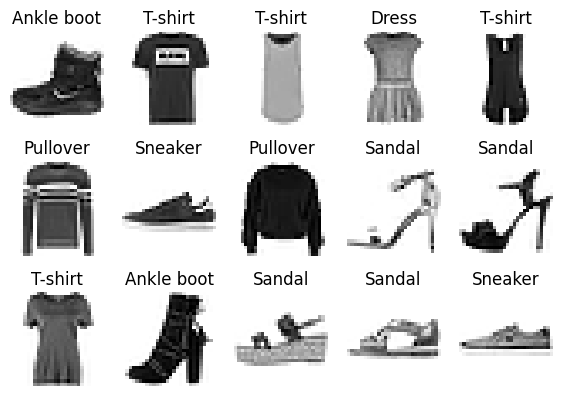

In [49]:
def show_imgs(n_rows, n_cols, train_ds, class_names):
    assert n_rows * n_cols < len(train_ds)  #确保打印的图片小于总样本数
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))  #宽1.4高1.6，宽，高
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col  # 计算索引，从0开始
            plt.subplot(n_rows, n_cols, index+1) # 因为从1开始
            img_arr, label = train_ds[index]
            img_arr = np.transpose(img_arr, (1, 2, 0))  # 通道换到最后一维
            plt.imshow(img_arr, cmap="binary",interpolation = 'nearest') # interpolation='nearest'是临近插值
            plt.axis('off') # 去除坐标系
            plt.title(class_names[label]) # 显示类别名称
    plt.show()

# 已知的图片类别
# lables在这个路径https://github.com/zalandoresearch/fashion-mnist
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot'] #0-9分别代表的类别
#只是打印了前15个样本
show_imgs(3, 5, train_ds, class_names)


In [50]:
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True) #batch_size分批，shuffle洗牌
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

In [51]:
for datas, labels in train_loader: 
    print(datas.shape)
    print(labels.shape)
    break

for datas, labels in val_loader:
    print(datas.shape)
    print(labels.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])
torch.Size([32, 1, 28, 28])
torch.Size([32])


在PyTorch中，`DataLoader`是一个迭代器，它封装了数据的加载和预处理过程，使得在训练机器学习模型时可以方便地批量加载数据。`DataLoader`主要负责以下几个方面：

1. **批量加载数据**：`DataLoader`可以将数据集（Dataset）切分为更小的批次（batch），每次迭代提供一小批量数据，而不是单个数据点。这有助于模型学习数据中的统计依赖性，并且可以更高效地利用GPU等硬件的并行计算能力。

2. **数据打乱**：默认情况下，`DataLoader`会在每个epoch（训练周期）开始时打乱数据的顺序。这有助于模型训练时避免陷入局部最优解，并且可以提高模型的泛化能力。

3. **多线程数据加载**：`DataLoader`支持多线程（通过参数`num_workers`）来并行地加载数据，这可以显著减少训练过程中的等待时间，尤其是在处理大规模数据集时。

4. **数据预处理**：`DataLoader`可以与`transforms`结合使用，对加载的数据进行预处理，如归一化、标准化、数据增强等操作。

5. **内存管理**：`DataLoader`负责管理数据的内存使用，确保在训练过程中不会耗尽内存资源。

6. **易用性**：`DataLoader`提供了一个简单的接口，可以很容易地集成到训练循环中。



In [52]:
# 定义网络结构, 初始化模型参数
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() # 继承父类的初始化方法，子类有父类的属性
        self.flatten = nn.Flatten()  # 展平层，二维变一维(高维变低维)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 300),  # in_features=784, out_features=300, 784是输入特征数，300是输出特征数
            nn.ReLU(), # 激活函数
            nn.Linear(300, 100),#隐藏层神经元数100
            nn.ReLU(), # 激活函数
            nn.Linear(100, 10),#输出层神经元数10，因为共有10个类别
        )

    def forward(self, x): # 前向计算（前向传播），必须叫forward，不能是其他名字
        # x.shape [batch size, 1, 28, 28]
        x = self.flatten(x)  
        # 展平后 x.shape [batch size, 784]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 10]
        return logits #没有经过softmax,称为logits
    
model = NeuralNetwork()

In [53]:
# 看看网络结构
model # bias=True表示有偏置

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [54]:
# 计算参数量
784*300+300+300*100+100+100*10+10

266610

In [55]:
for name, param in model.named_parameters(): # 打印模型参数
      print(name, param.shape)

linear_relu_stack.0.weight torch.Size([300, 784])
linear_relu_stack.0.bias torch.Size([300])
linear_relu_stack.2.weight torch.Size([100, 300])
linear_relu_stack.2.bias torch.Size([100])
linear_relu_stack.4.weight torch.Size([10, 100])
linear_relu_stack.4.bias torch.Size([10])


In [56]:
# 看看模型参数
list(model.parameters())  # 这种方法拿到模型的所有可学习参数,requires_grad=True

[Parameter containing:
 tensor([[-0.0321,  0.0339, -0.0019,  ...,  0.0138, -0.0301, -0.0120],
         [ 0.0121, -0.0200, -0.0113,  ...,  0.0012, -0.0107,  0.0239],
         [-0.0007, -0.0174, -0.0079,  ...,  0.0334,  0.0152,  0.0286],
         ...,
         [-0.0028,  0.0026, -0.0292,  ...,  0.0209,  0.0144,  0.0302],
         [-0.0279, -0.0193, -0.0209,  ..., -0.0184, -0.0139, -0.0073],
         [-0.0163,  0.0277,  0.0113,  ...,  0.0032,  0.0208, -0.0226]],
        requires_grad=True),
 Parameter containing:
 tensor([ 5.8332e-03, -5.1517e-03, -3.3563e-03,  3.1040e-02, -1.8295e-02,
          1.9040e-02,  3.5037e-02,  7.4524e-03, -3.1990e-02,  4.5494e-03,
         -2.2574e-02,  3.1026e-02,  1.1555e-02, -9.9702e-03, -7.6644e-03,
         -6.3094e-03,  2.9101e-02,  2.4209e-03,  2.2934e-02,  3.5099e-02,
          3.4533e-02, -2.5887e-02, -2.0987e-02, -3.0301e-02, -3.3434e-02,
         -2.2797e-02, -2.9193e-02, -8.1291e-03,  3.9732e-03, -2.0847e-02,
          3.4958e-02,  1.0271e-02,  2.78

## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [57]:
# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss() # 传入的是logits和labels，lables会转为one-hot编码，内部先做softmax，然后计算交叉熵
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package,随机梯度下降
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # 用于更新梯度的优化器，lr学习率，momentum动量

In [58]:
from sklearn.metrics import accuracy_score  # 导入准确率计算函数

@torch.no_grad()  # 装饰器，禁止反向传播，节省内存
def evaluating(model, dataloader, loss_fct):
    """
    评估模型在验证集上的表现，包括计算损失和准确率。
    
    参数：
    - model: 已训练的模型
    - dataloader: 用于加载验证集数据的 DataLoader 对象
    - loss_fct: 损失函数，用于计算模型输出与真实标签之间的损失
    
    返回：
    - 平均损失和准确率
    """
    
    loss_list = []  # 用于记录每次计算的损失
    pred_list = []  # 用于记录模型的预测
    label_list = []  # 用于记录真实标签
    
    for datas, labels in dataloader:  # 遍历每一个batch的数据，dataloader 会自动批量化数据
        datas = datas.to(device)  # 将数据移动到 GPU 或者 CPU 进行计算
        labels = labels.to(device)  # 同样移动标签到设备
        
        # 前向计算：通过模型得到预测结果
        logits = model(datas)
        
        # 计算损失
        loss = loss_fct(logits, labels)  # 根据模型输出和真实标签计算损失
        loss_list.append(loss.item())  # 将当前损失值记录下来
        
        # 计算预测类别
        preds = logits.argmax(axis=-1)  # 获取预测类别（最大值所在索引，即 argmax）
        
        # 将预测结果转换为 NumPy 数组并追加到 pred_list
        pred_list.extend(preds.cpu().numpy().tolist())  # 将预测结果从 GPU 转到 CPU 后转换为 NumPy 数组
        label_list.extend(labels.cpu().numpy().tolist())  # 同样处理标签

    # 计算平均损失
    avg_loss = np.mean(loss_list)  # 对所有损失求平均
    # 计算准确率
    acc = accuracy_score(label_list, pred_list)  # 使用 sklearn 计算准确率
    
    return avg_loss, acc  # 返回平均损失和准确率


In [59]:
# 定义训练函数 eval_step 验证步数
def training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=500):
    # 初始化记录字典，用于存储训练和验证的损失与准确率
    record_dict = {
        "train": [],  # 存储训练集的损失和准确率
        "val": []     # 存储验证集的损失和准确率
    }
    
    global_step = 0  # 全局步数计数器，用于记录当前训练步数
    model.train()    # 将模型切换到训练模式
    
    # 使用 tqdm 创建进度条，显示总训练过程
    # epoch * len(train_loader) 计算总训练步数，等于 epoch 次数乘以每轮训练的步数
    with tqdm(total=epoch * len(train_loader)) as pbar:
        # 按训练轮数迭代
        for epoch_id in range(epoch): 
            # 遍历训练数据加载器（每批数据一次）
            for datas, labels in train_loader: 
                # 将数据和标签传输到指定设备（例如 GPU）
                datas = datas.to(device)  # 数据张量尺寸为 [batch_size, 1, 28, 28]
                labels = labels.to(device)  # 标签张量尺寸为 [batch_size]

                # 清空梯度，避免累积之前的梯度值
                optimizer.zero_grad()
                
                # 模型前向计算，得到预测值 logits
                logits = model(datas)
                
                # 使用损失函数计算预测值与实际值之间的损失
                loss = loss_fct(logits, labels)
                
                # 反向传播计算梯度
                loss.backward()
                
                # 更新模型参数，使用优化器根据梯度调整权重
                optimizer.step()

                # 预测标签，取 logits 中最大值的索引作为预测类别
                preds = logits.argmax(axis=-1)
                
                # 计算当前批次的准确率
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                
                # 将损失值转换到 CPU，并提取标量值
                loss = loss.cpu().item()
                
                # 记录训练集的损失、准确率以及当前步数
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                
                # 每隔 eval_step 步进行一次验证
                if global_step % eval_step == 0:
                    # 将模型切换到评估模式（冻结 dropout 等训练特定操作）
                    model.eval()
                    
                    # 调用验证函数计算验证集损失与准确率
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    
                    # 记录验证集的损失、准确率以及当前步数
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    
                    # 验证完成后切回训练模式
                    model.train()
                
                # 更新全局步数
                global_step += 1
                
                # 更新进度条的状态
                pbar.update(1)  # 每完成一步更新进度条
                pbar.set_postfix({"epoch": epoch_id})  # 显示当前轮次
        
    return record_dict  # 返回训练与验证记录

# 设置训练轮数
epoch = 20  # 可以调整为更大值，如 40
model = model.to(device)  # 将模型传输到指定设备（例如 GPU）

# 调用训练函数，开始训练模型
record = training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=1000)

  0%|          | 0/37500 [00:00<?, ?it/s]

In [60]:
print(f"总步数：{(60000 / 32) * 20}")

总步数：37500.0


In [61]:
record["train"][-5:]

[{'loss': 0.35447072982788086, 'acc': 0.84375, 'step': 37495},
 {'loss': 0.2543526887893677, 'acc': 0.84375, 'step': 37496},
 {'loss': 0.27415382862091064, 'acc': 0.875, 'step': 37497},
 {'loss': 0.15588068962097168, 'acc': 0.96875, 'step': 37498},
 {'loss': 0.17533035576343536, 'acc': 0.9375, 'step': 37499}]

In [62]:
record["val"][-5:]

[{'loss': np.float64(0.36217643505039687), 'acc': 0.8708, 'step': 33000},
 {'loss': np.float64(0.37227248830107834), 'acc': 0.8648, 'step': 34000},
 {'loss': np.float64(0.35296877400991256), 'acc': 0.8736, 'step': 35000},
 {'loss': np.float64(0.35347033482485307), 'acc': 0.8737, 'step': 36000},
 {'loss': np.float64(0.35096140352253336), 'acc': 0.8729, 'step': 37000}]

step
0        0.12500
1000     0.62500
2000     0.71875
3000     0.81250
4000     0.84375
5000     0.90625
6000     0.71875
7000     0.90625
8000     0.68750
9000     0.90625
10000    0.84375
11000    0.78125
12000    0.84375
13000    0.78125
14000    0.87500
15000    0.84375
16000    0.90625
17000    0.81250
18000    0.87500
19000    0.81250
20000    0.87500
21000    1.00000
22000    0.96875
23000    0.81250
24000    0.87500
25000    0.87500
26000    0.87500
27000    0.87500
28000    0.93750
29000    0.93750
30000    0.90625
31000    0.90625
32000    0.96875
33000    0.90625
34000    0.84375
35000    0.90625
36000    0.84375
37000    0.93750
Name: acc, dtype: float64
step
0        0.1164
1000     0.6902
2000     0.7656
3000     0.7960
4000     0.8152
5000     0.8159
6000     0.8282
7000     0.8248
8000     0.8322
9000     0.8328
10000    0.8374
11000    0.8377
12000    0.8456
13000    0.8456
14000    0.8434
15000    0.8447
16000    0.8480
17000    0.8534
18000    0.8571
19000    0.850

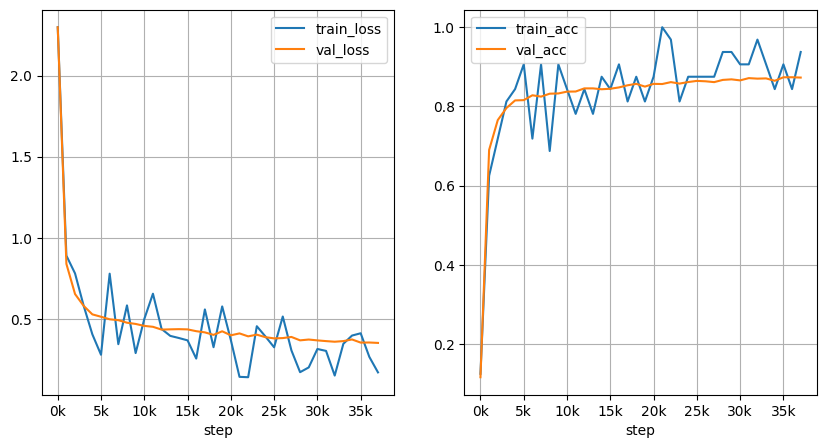

In [65]:
import matplotlib.pyplot as plt
import pandas as pd

# 画学习曲线图的函数
# 注意：损失（loss）不一定在零到一之间
def plot_learning_curves(record_dict, sample_step=1000):
    """
    绘制训练过程中损失和准确率的学习曲线图
    :param record_dict: 包含训练和验证记录的字典，格式为 {'train': [...], 'val': [...] }
    :param sample_step: 训练过程中的采样步数，默认每1000步采样一次
    """
    
    # 将训练集和验证集的记录转化为 DataFrame 并设置索引为步骤（step）
    # 训练集的数据根据样本步长进行采样（例如，每隔 sample_step 步）
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")
    
    # 获取训练数据中最后一个 step（步数）用于设置 x 轴范围
    last_step = train_df.index[-1]  # 最后一步的步数
    
    # 打印训练集和验证集的准确率（acc）数据用于调试
    print(train_df['acc'])
    print(val_df['acc'])
    
    # 根据 train_df 的列数决定画多少张子图，通常有损失（loss）和准确率（acc）
    fig_num = len(train_df.columns)  # 画几张图，分别是损失和准确率
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))  # 创建子图，水平排列
    
    # 遍历 train_df 中的列，分别绘制损失和准确率
    for idx, item in enumerate(train_df.columns):
        # 绘制训练集的数据
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        # 绘制验证集的数据
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        
        # 显示网格
        axs[idx].grid()
        # 显示图例，区分训练集和验证集的曲线
        axs[idx].legend()
        
        # 设置 x 轴刻度，每 5000 步显示一个刻度
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        
        # 设置 x 轴标签，表示训练步骤，以 'k' 为单位（例如：5k，10k）
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, last_step, 5000)))
        
        # 设置 x 轴标签为 "step"，表示步数
        axs[idx].set_xlabel("step")
    
    # 显示图表
    plt.show()

# 调用函数绘制学习曲线
# 假设 `record` 是包含训练记录的字典，包含 `train` 和 `val` 键
plot_learning_curves(record)  # 横坐标是 steps

In [64]:
# dataload for evaluating

model.eval() # 进入评估模式
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:{loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3604
accuracy: 0.8719
